In [25]:
import pandas as pd
import numpy as np
import json
from fixed_token_chunker import FixedTokenChunker as FTChunker
from embedding_function import embed_texts 

In [26]:
def sum_of_ranges(ranges):
    if ranges is None:
        return 0
    return sum(end - start for start,end in ranges)

def union(ranges):
    if not ranges:
        return [] 
    sorted_ranges = sorted(ranges)
    merged_ranges = [sorted_ranges[0]]
    for curr in sorted_ranges[1:]:
        last_start, last_end = merged_ranges[-1]
        if curr[0] <= last_end:
            merged_ranges[-1] = (last_start, max(last_end,curr[1]))
        else:
            merged_ranges.append(curr)
    return merged_ranges

def intersect_2(range1,range2):
    start = max(range1[0],range2[0])
    end   = min(range1[1],range2[1])

    return (start,end) if end > start else None

def get_all_valid(valid,retrieved):
    ret = []
    for target in valid:
        for range in retrieved:
            intersection = intersect_2(range,target) 
            if intersection is not None:
                ret.append(intersection)
    return union(ret)


In [27]:
#tests
ranges = [(1,2),(3,7),(4,6),(2,5)]
print(sum_of_ranges(ranges))
print(union(ranges))
union([(1,2)])

print(intersect_2(ranges[0],ranges[1]))
print(intersect_2(ranges[1],ranges[2]))
print(intersect_2(ranges[3],ranges[1]))


10
[(1, 7)]
None
(4, 6)
(3, 5)
[(1, 2), (3, 5), (6, 7), (4, 5), (2, 5)]


In [28]:
def score_calc(retrived, relevant): 
    numerator_ranges = get_all_valid(retrived, relevant)
    numerator = sum_of_ranges(numerator_ranges)
    denum_precission = sum_of_ranges(retrived)
    denum_recall = sum_of_ranges(relevant)

    precission = numerator/denum_precission
    recall =  numerator/denum_recall

    return precission,recall

In [29]:
def get_golden(references):
    ret = []
    for reference in references:
        ret.append((reference["start_index"], reference["end_index"]))
    return ret


In [30]:
def compute_cosine_similarity(query, matrix):
    query = query / np.linalg.norm(query)
    matrix = matrix / np.linalg.norm(matrix, axis=1, keepdims=True)
    return np.dot(matrix, query)


In [31]:
def find_target_in_document(document, target):
    start_index = document.find(target)
    if start_index == -1:
        return None
    end_index = start_index + len(target)
    return start_index, end_index

In [32]:
def evaluate_retrieval(dataset, corpus,  embedding_function, corpus_chunks, chunk_embeddings, num_retrieved):
    """
    For each question in the evaluation dataset:
      1. Compute query embedding.
      2. Retrieve top-N similar corpus chunks.
      3. Evaluate retrieval quality (here, as a simple binary metric: 1 if any retrieved chunk contains the golden excerpt, else 0).
    """
    results = []
    for item in dataset.iloc():
        question = item["question"]
        references = item['references']
        golden_ranges =  get_golden(references)
        
        # Generate query embedding using the provided embedding function.
        query_emb = embedding_function(question)
        
        # Compute similarity scores between the query and each corpus chunk.
        similarities = compute_cosine_similarity(query_emb, chunk_embeddings)
        
        # Retrieve the indices of the top-N most similar chunks.
        top_indices = np.argsort(-similarities)[:num_retrieved]
        retrieved_chunks = [corpus_chunks[i] for i in top_indices]
        retrieved_ranges = [find_target_in_document (corpus, chunk) for chunk in retrieved_chunks]
        

        precision,recall = score_calc(retrieved_ranges, golden_ranges)
        
        results.append({
            "question": question,
            "retrieved_chunks": retrieved_chunks,
            "precision": precision,
            "recall" : recall
        })
    
    # Compute average metric over all queries.
    avg_precission = np.mean([r["precision"] for r in results])
    avg_recall = np.mean([r["recall"] for r in results])

    return avg_precission, avg_recall

In [33]:
def chunk_and_embed(chunker, embedding_function):
    with open("data/state_of_the_union.md", "r", encoding="utf-8") as f:
        corpus = f.read()


    dataset = pd.read_csv("data/questions_state.csv", encoding = "utf-8",  converters={"references": json.loads})
    
    # Process the corpus into chunks using provided chunker.
    corpus_chunks = chunker.split_text(corpus)

    # print(corpus_chunks[0])

    # Generate embeddings for each chunk.
    chunk_embeddings = []
    for chunk in corpus_chunks:
        emb = embedding_function(chunk)
        chunk_embeddings.append(emb)

    return dataset,corpus,corpus_chunks,chunk_embeddings

In [34]:
def run_pipeline(chunker, embedding_function, num_retrieved):
    dataset,corpus,corpus_chunks,chunk_embeddings = chunk_and_embed(chunker,embedding_function)
    return evaluate_retrieval(dataset, corpus, embed_texts, corpus_chunks, chunk_embeddings, num_retrieved)


In [35]:
# chunker = FTChunker(chunk_size=400,chunk_overlap=200)
# run_pipeline(chunker, embed_texts, 5)

In [38]:
tests = [(100,0), (100,25), (100,50), (200,0), (200,50), (200,100), (400,0), (400, 100), (400,200), (600,0), (600,125) , (600,300), (800,0) , (800,100), (800,200), (800,400)]
results = []
for c_len,c_overlap in tests:
    chunker = FTChunker(chunk_size=c_len,chunk_overlap=c_overlap)
    dataset,corpus,corpus_chunks,chunk_embeddings = chunk_and_embed(chunker,embed_texts)
    for num in (1,2,3,5,10):
        avg_precission,avg_recall = evaluate_retrieval(dataset,corpus,embed_texts,corpus_chunks,chunk_embeddings,num)
        results.append({
            "chunk_size" : c_len,
            "chunk_overlap": c_overlap,
            "chunks_retieved": num,
            "precision": avg_precission,
            "recall" : avg_recall
        })
        print("ok")
    
    

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


In [39]:
df = pd.DataFrame(results)
df.to_csv("experiment_comparison_table.csv", index=False)

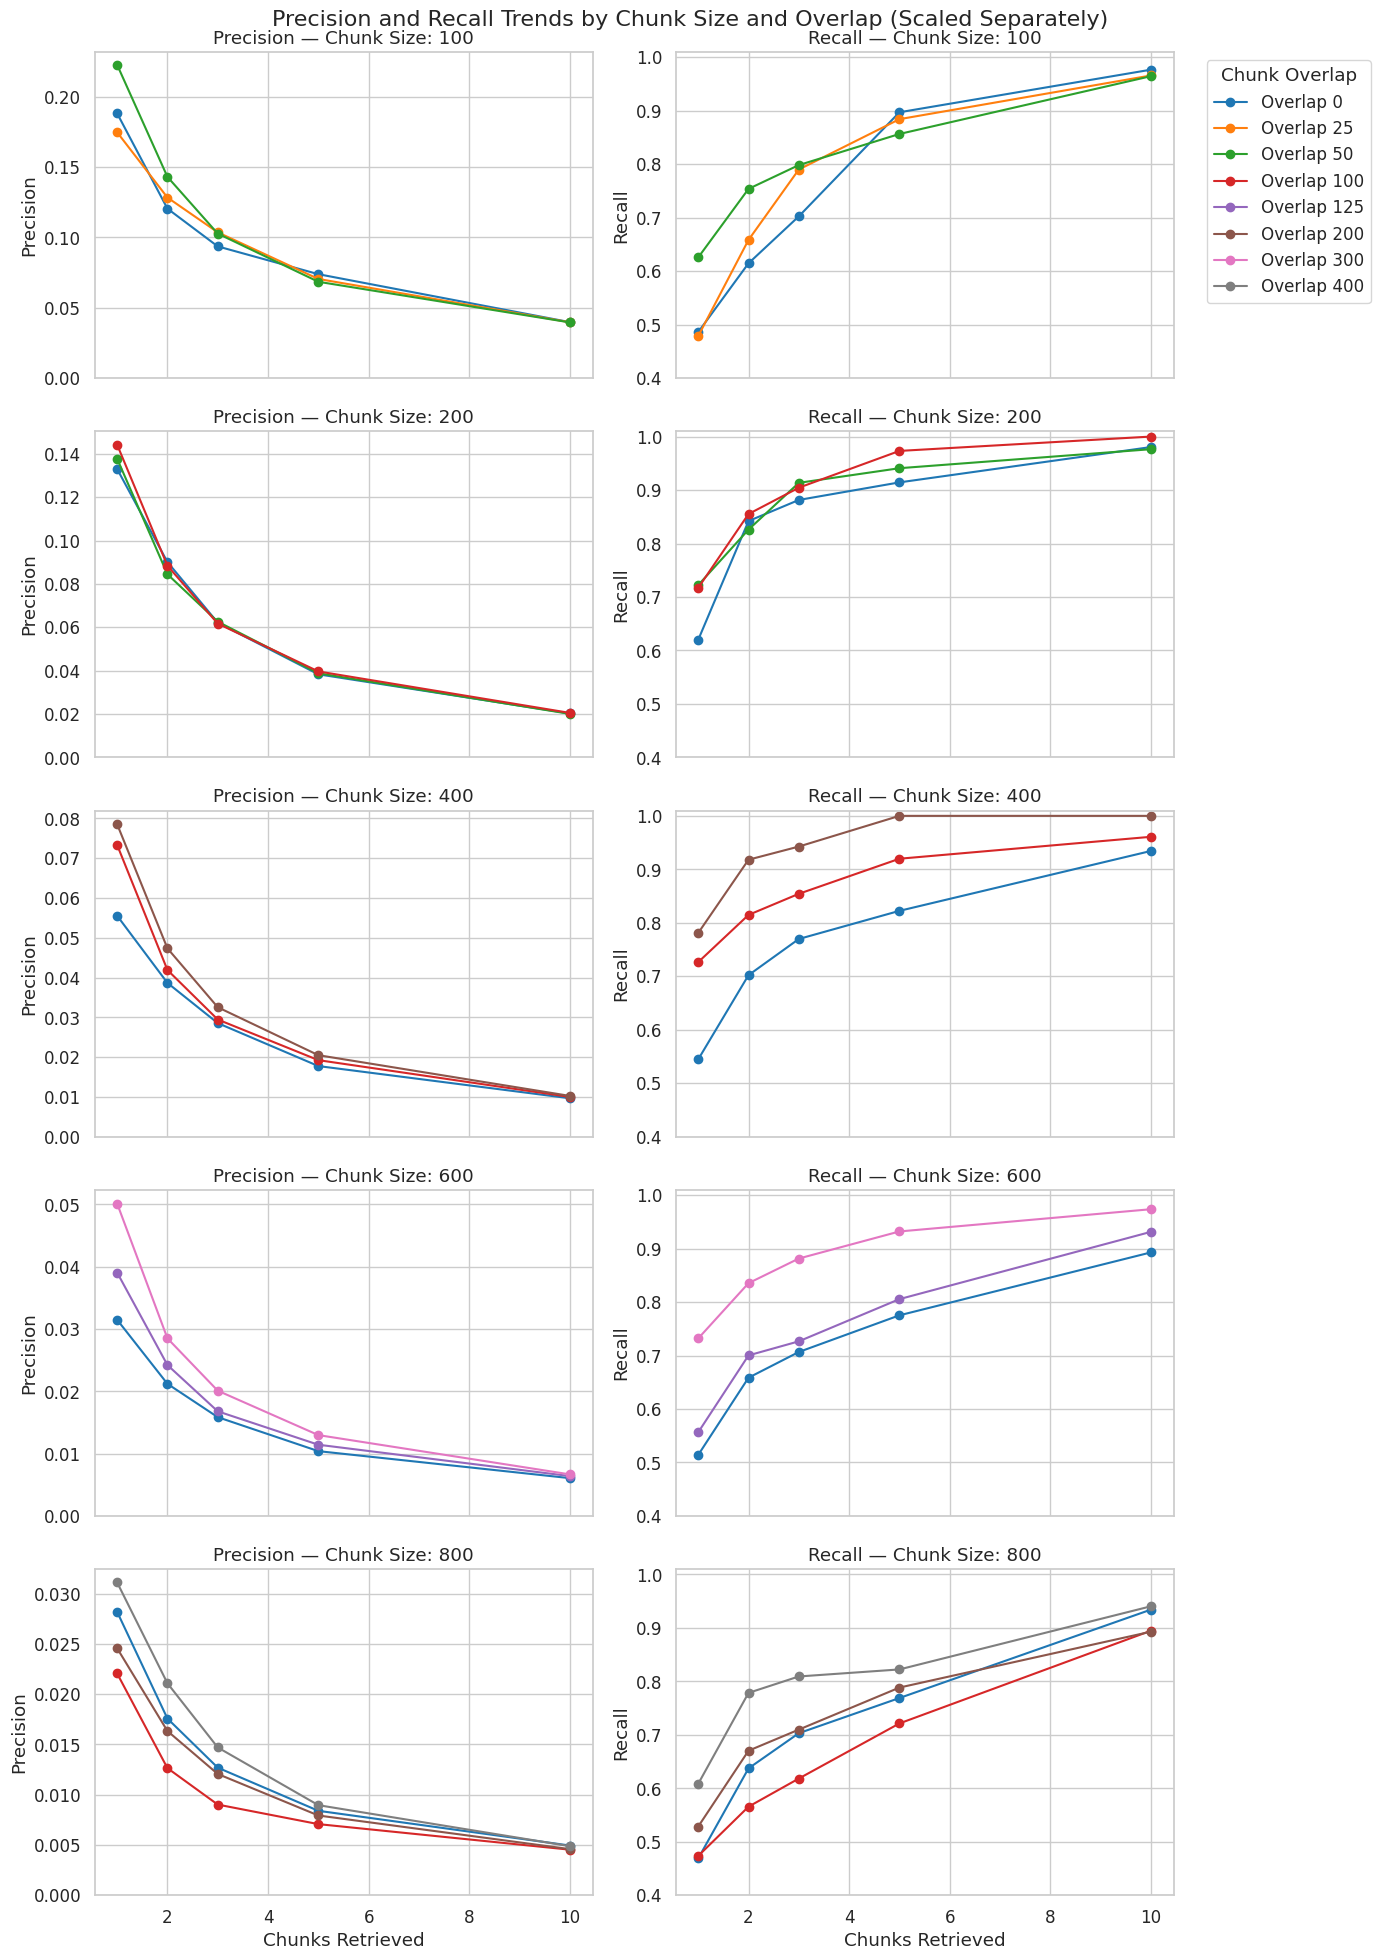

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("experiment_comparison_table.csv")
df = df.dropna()

sns.set(style="whitegrid", font_scale=1.1)
chunk_sizes = sorted(df["chunk_size"].unique())
overlaps = sorted(df["chunk_overlap"].unique())
colors = sns.color_palette("tab10", len(overlaps))

# Subplots
fig, axes = plt.subplots(len(chunk_sizes), 2, figsize=(14, 4 * len(chunk_sizes)), sharex=True)

for i, chunk_size in enumerate(chunk_sizes):
    subset = df[df["chunk_size"] == chunk_size]
    
    for j, metric in enumerate(["precision", "recall"]):
        ax = axes[i, j]
        
        for overlap, color in zip(overlaps, colors):
            data = subset[subset["chunk_overlap"] == overlap].sort_values("chunks_retieved")
            ax.plot(data["chunks_retieved"], data[metric], label=f"Overlap {overlap}", marker='o', color=color)
        
        ax.set_ylabel(metric.capitalize())
        if metric == "recall":
            ax.set_ylim(0.4, 1.01)  
        else:
            ax.set_ylim(bottom=0)  # auto top for precision to emphasize variation
        
        if i == len(chunk_sizes) - 1:
            ax.set_xlabel("Chunks Retrieved")
        ax.set_title(f"{metric.capitalize()} — Chunk Size: {chunk_size}")
        ax.grid(True)
        
        if i == 0 and j == 1:
            ax.legend(title="Chunk Overlap", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.suptitle("Precision and Recall Trends by Chunk Size and Overlap (Scaled Separately)", fontsize=16)
plt.show()